# first steps
firstly, we want to calculate price elasticity of each item. for starters, lets load the data, figureout hte categories from scraping data. 

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import re
import io
import time

# Load environment variables
load_dotenv('../../.env')

# Create the engine
def get_engine():
    db_user = os.getenv('DB_USER')
    db_password = os.getenv('DB_PASSWORD') 
    db_host = os.getenv('DB_HOST')
    db_port = os.getenv('DB_PORT')
    db_database = os.getenv('DB_DATABASE')
    
    connection_string = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_database}"
    
    engine = create_engine(
        connection_string,
        connect_args={
            "sslmode": "require"  # Azure PostgreSQL requires SSL
        }
    )
    return engine

def format_query(query_text, params):
    """
    Format query by replacing $(param_name) with actual values
    Similar to the Node.js formatQuery function
    """
    formatted_query = query_text
    for key, value in params.items():
        # Replace $(key) with the actual value
        pattern = f"\\$\\({key}\\)"
        if isinstance(value, str):
            formatted_query = re.sub(pattern, f"'{value}'", formatted_query)
        else:
            formatted_query = re.sub(pattern, str(value), formatted_query)
    
    return formatted_query

def run_query(query_filename, rawQuery=None, params=None, engine=None):
    """
    Run a SQL query from a file with parameters
    Similar to the Node.js runQuery function
    """
    if engine is None:
        engine = get_engine()
    
    if params is None:
        params = {}
    
    try:
        if rawQuery is None:
            # Read the SQL file
            query_path = os.path.join('queries', query_filename)
            with open(query_path, 'r') as file:
                query_text = file.read()
        else:
            query_text = rawQuery
        
        # Format the query with parameters
        formatted_query = format_query(query_text, params)
        
        # Execute the query and return DataFrame
        df = pd.read_sql(formatted_query, engine)
        return df
        
    except Exception as error:
        print(f"Error while running query: {query_filename} -> {error}")
        print(f"Formatted query:\n{formatted_query}")
        raise error
    

def write_to_table(df, schema_name, table_name, engine=None):
    """
    Write a DataFrame to a table
    """
    if engine is None:
        engine = get_engine()
     # 1) Create empty table matching df’s schema
    df.head(0).to_sql(
        table_name,
        engine,
        schema=schema_name,
        if_exists='replace',
        index=False
    )

    # 2) stream via COPY with quoted columns
    buffer = io.StringIO()
    df.to_csv(buffer, index=False, header=False)
    buffer.seek(0)

    cols = ', '.join(f'"{col}"' for col in df.columns)
    copy_sql = (
        f'COPY "{schema_name}"."{table_name}" ({cols}) '
        'FROM STDIN WITH (FORMAT csv)'
    )

    conn   = engine.raw_connection()
    cursor = conn.cursor()
    try:
        cursor.copy_expert(copy_sql, buffer)
        conn.commit()
    finally:
        cursor.close()
        conn.close()



In [2]:
# load data from csv analysis_cleaned 

df = pd.read_csv('data/analysis_cleaned.csv')
df.head()

,bb_id,period_id,period_start_local,period_end_local,on_promotion,merchant_id,store_id,item_id,name,day,...,avg_basket_size,promo_spending,revenue,profit,revenue_to_promo_spending_ratio,promo_spending (selling_price_based),revenue (selling_price_based),profit (selling_price_based),revenue_to_promo_spending_ratio (selling_price_based),filled_from
0,8902.0,0,2024-06-21 00:00:00,2024-07-05 00:00:00,False,17,1173,8225800,Frozen Udon 2.75lb(1.25kg),2024-06-21,...,151.32,NaN,5.99,4.0744,NaN,1.111317,5.39,3.4744,4.8501,"{""unit_cost"":""2025-06-02""}"
1,8902.0,0,2024-06-21 00:00:00,2024-07-05 00:00:00,False,17,1173,8225800,Frozen Udon 2.75lb(1.25kg),2024-06-22,...,151.90,NaN,5.99,4.0744,NaN,1.111317,5.39,3.4744,4.8501,"{""unit_cost"":""2025-06-02""}"
2,8902.0,0,2024-06-21 00:00:00,2024-07-05 00:00:00,False,17,1173,8225800,Frozen Udon 2.75lb(1.25kg),2024-06-23,...,0.00,NaN,0.00,0.0000,NaN,0.000000,0.00,0.0000,NaN,"{""regular_price"":""2024-06-22"",""avg_selling_pri..."
3,8902.0,0,2024-06-21 00:00:00,2024-07-05 00:00:00,False,17,1173,8225800,Frozen Udon 2.75lb(1.25kg),2024-06-24,...,0.00,NaN,0.00,0.0000,NaN,0.000000,0.00,0.0000,NaN,"{""regular_price"":""2024-06-22"",""avg_selling_pri..."
4,8902.0,0,2024-06-21 00:00:00,2024-07-05 00:00:00,False,17,1173,8225800,Frozen Udon 2.75lb(1.25kg),2024-06-25,...,0.00,NaN,0.00,0.0000,NaN,0.000000,0.00,0.0000,NaN,"{""regular_price"":""2024-06-22"",""avg_selling_pri..."


In [ ]:
# fire a query to get the category for each bb_id for hmart items
query = """SELECT bb_id, item_info from scraping.items where merchant_id = 17"""
time_start = time.time()
df_categories = run_query(None, query)
time_end = time.time()
print(f"Time taken to get categories from query: {time_end - time_start} seconds")
df_categories.head(5)

# drop row if bb_id is nan 
df_categories = df_categories[df_categories['bb_id'].notna()]
# Create a mapping dictionary from item_info
category_mapping = df_categories.set_index('bb_id')['item_info'].to_dict()
# Add categories column using map
df['categories'] = df['bb_id'].map(category_mapping)

# # modify the values of the mapping to be a list of categories
# def extract_categories(cat_dict):
#     if pd.isna(cat_dict):
#         return []
    
#     # If it's a string representation of a dict, convert it
#     if isinstance(cat_dict, str):
#         try:
#             cat_dict = ast.literal_eval(cat_dict)
#         except:
#             return []
    
#     # If it's already a dict, extract values
#     if isinstance(cat_dict, dict):
#         return list(cat_dict.values())
    
#     return []

def extract_general_and_fine_categories(cat_dict):
    # find the most general category (category_0 key if it exists)
    if not isinstance(cat_dict, dict):
        return None, None

    # Pull out only the category_x keys, mapping their numeric suffix → value
    cats = {
        int(k.split('_')[1]): v
        for k, v in cat_dict.items()
        if k.startswith('category_') and k.split('_')[1].isdigit()
    }
    if not cats:
        return None, None

    # The most general is the lowest index; the most specific the highest
    min_idx, max_idx = min(cats), max(cats)
    return cats[min_idx], cats[max_idx]

# df['categories'] = df['categories'].apply(extract_categories)

# # create a mapping of categories to a list of items
# # for each item in a list of categories, add that to the key of a dict if it doenst already exist. then add the item to the list of items for that key

# 107 categories currently
time_start = time.time()
general_map = {}
specific_map = {}
for bb, cat_dict in category_mapping.items():      # category_mapping: bb_id → dict
    gen, spec = extract_general_and_fine_categories(cat_dict)
    general_map [bb] = gen
    specific_map[bb] = spec
time_end = time.time()
print(f"Time taken to create category_item_mapping: {time_end - time_start} seconds")

# use category_item_mapping to create new columns in df for general and specific categories
time_start = time.time()
df['general_category']  = df['bb_id'].map(general_map)
df['specific_category'] = df['bb_id'].map(specific_map)
time_end = time.time()
print(f"Time taken to create general and specific categories: {time_end - time_start} seconds")

# drop categories column 
df = df.drop(columns=['categories'])

df.head(5)

Time taken to get categories from query: 1.9282050132751465 seconds
{'category_0': 'Ramen & Noodle', 'category_1': 'Udon & Frozen Noodles'}


In [32]:
# for each item, we need to figure out unique active_prices and units_sold averaged by number of days that active price was available 
price_grouped = (
  df
  .groupby(['item_id','active_price'])
  .agg(
    # trivial aggregations
    bb_id = ('bb_id', 'first'),
    name = ('name', 'first'),
    categories = ('categories', 'first'),
    
    # actual aggregations
    avg_units_sold   = ('units_sold', 'mean'),
    days_at_price    = ('day',        'nunique'),
    
  )
  .reset_index()
)
price_grouped = price_grouped[['item_id', 'bb_id', 'name', 'categories', 'active_price', 'avg_units_sold', 'days_at_price']]
price_grouped.head(20)


,item_id,bb_id,name,categories,active_price,avg_units_sold,days_at_price
0,8225800,8902.0,Frozen Udon 2.75lb(1.25kg),"[Ramen & Noodle, Udon & Frozen Noodles]",3.49,3.375000,56
1,8225800,8902.0,Frozen Udon 2.75lb(1.25kg),"[Ramen & Noodle, Udon & Frozen Noodles]",5.99,0.479365,315
2,8225801,2319.0,Golden Curry Sauce Mix Mild 7.8oz(220g),"[Instant & Quick Food, Curry & Jjajang & Soup]",2.99,3.281250,17
3,8225801,2319.0,Golden Curry Sauce Mix Mild 7.8oz(220g),"[Instant & Quick Food, Curry & Jjajang & Soup]",3.49,3.830189,54
4,8225801,2319.0,Golden Curry Sauce Mix Mild 7.8oz(220g),"[Instant & Quick Food, Curry & Jjajang & Soup]",3.99,4.832000,64
5,8225801,2319.0,Golden Curry Sauce Mix Mild 7.8oz(220g),"[Instant & Quick Food, Curry & Jjajang & Soup]",4.49,2.916667,110
6,8225801,2319.0,Golden Curry Sauce Mix Mild 7.8oz(220g),"[Instant & Quick Food, Curry & Jjajang & Soup]",4.99,2.517110,137
7,8225802,4439.0,Duck Packaged Fz Smoked/Sliced Half Duck (1 Pack),"[Meat, Duck,Others]",25.99,3.256410,39
8,8225802,4439.0,Duck Packaged Fz Smoked/Sliced Half Duck (1 Pack),"[Meat, Duck,Others]",27.99,3.862069,29
9,8225802,4439.0,Duck Packaged Fz Smoked/Sliced Half Duck (1 Pack),"[Meat, Duck,Others]",29.99,1.000000,63


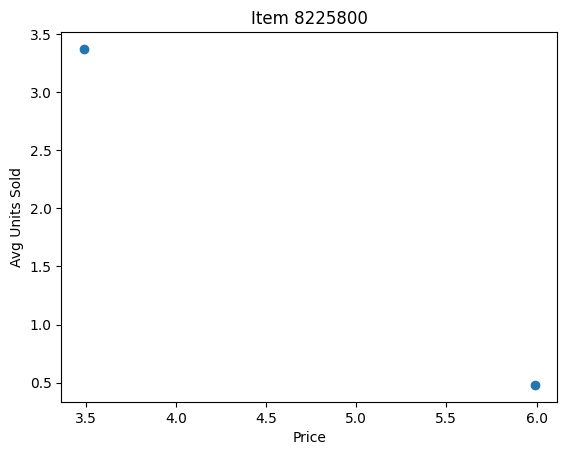

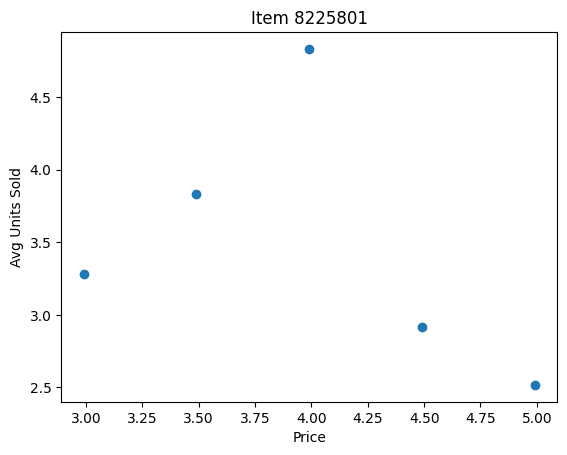

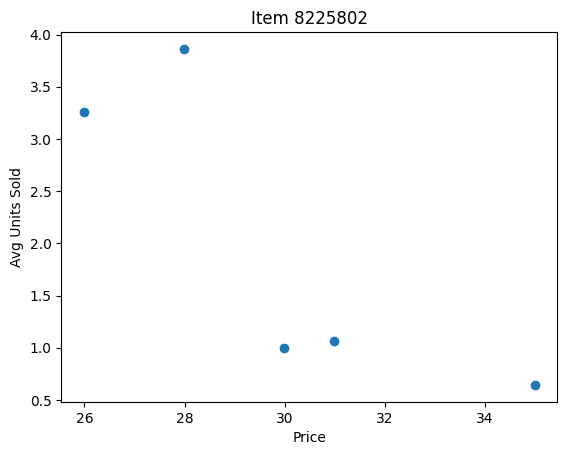

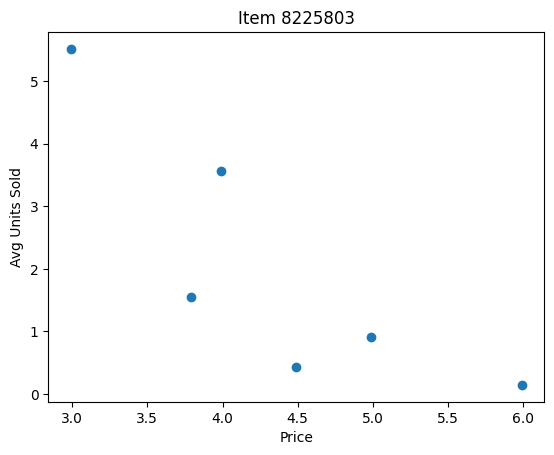

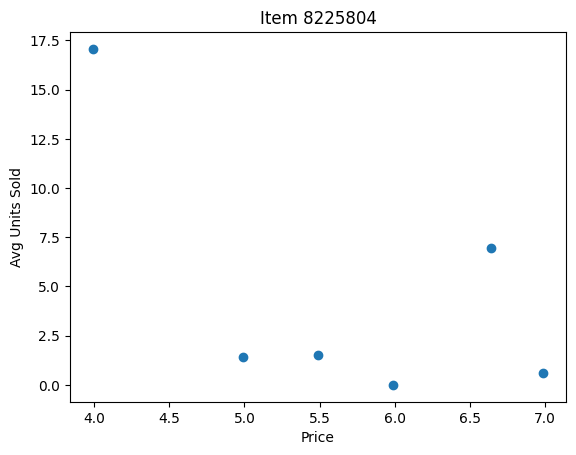

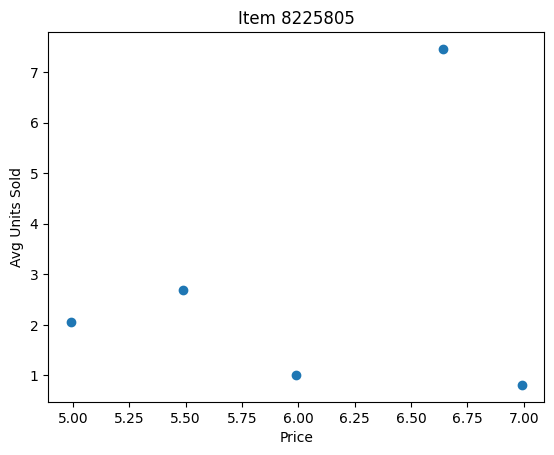

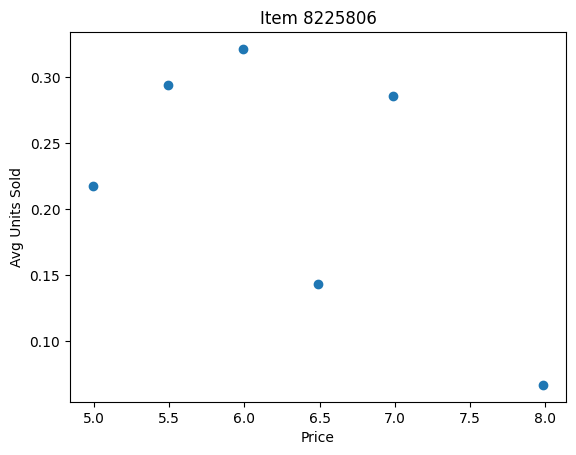

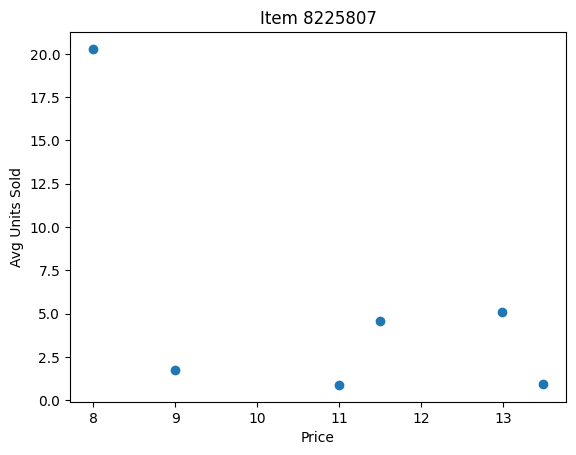

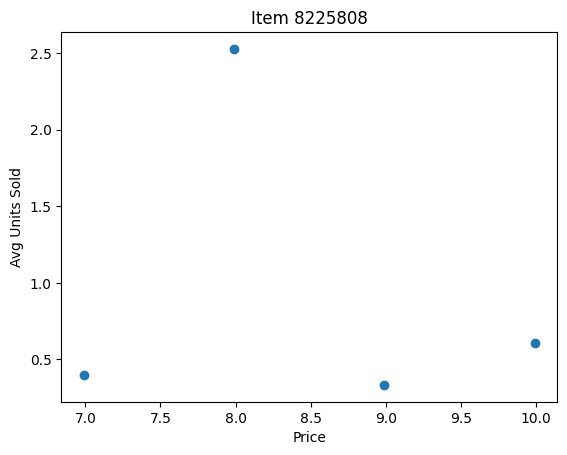

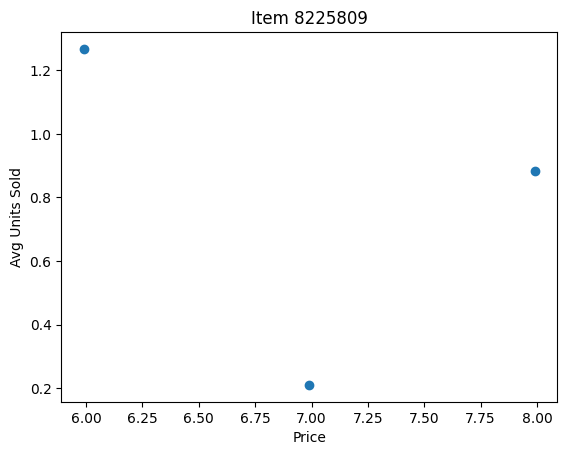

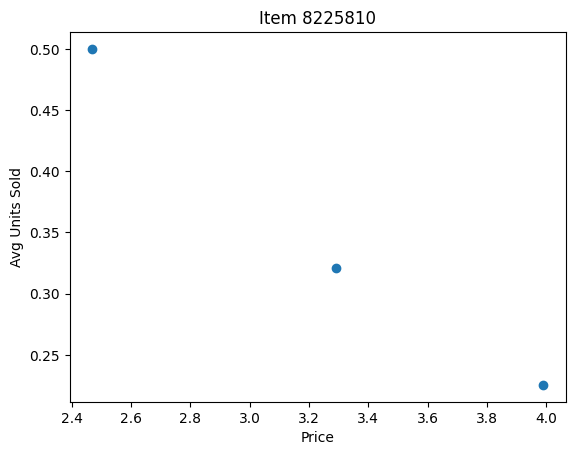

Best price block:
  Price = $13.99,  Avg Qty = 28.4,  Revenue ≈ $397.72


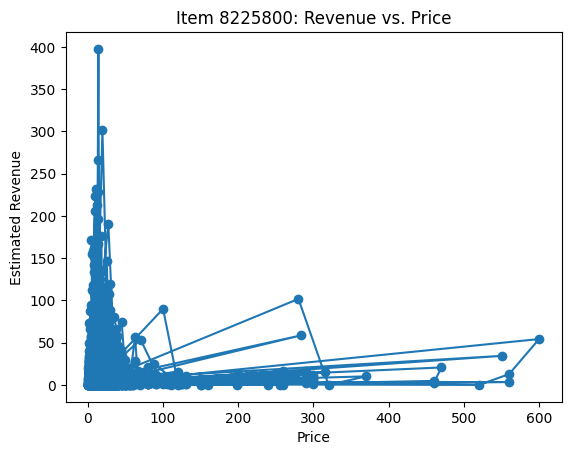

In [15]:
import numpy as np
import matplotlib.pyplot as plt

count = 0

# If you want one chart per item, wrap the above in a loop:
for item, grp in price_grouped.groupby('item_id'):
    plt.figure()
    plt.scatter(grp['active_price'], grp['avg_units_sold'])
    plt.xlabel('Price')
    plt.ylabel('Avg Units Sold')
    plt.title(f'Item {item}')
    plt.show()
    count += 1
    if count > 10:
        break


# ─── 2) “Optimal” price by max(revenue) ─────────────────────────────────
# Compute (approximate) revenue at each price‐block:
price_grouped['est_revenue'] = price_grouped['active_price'] * price_grouped['avg_units_sold']

# Find the price that gave the highest historical revenue:
best = price_grouped.loc[price_grouped['est_revenue'].idxmax()]
print("Best price block:")
print(f"  Price = ${best['active_price']:.2f},  Avg Qty = {best['avg_units_sold']:.1f},  Revenue ≈ ${best['est_revenue']:.2f}")

# Optional: plot revenue curve too
plt.figure()
plt.plot(price_grouped['active_price'], price_grouped['est_revenue'], marker='o')
plt.xlabel('Price')
plt.ylabel('Estimated Revenue')
plt.title(f'Item {price_grouped["item_id"].iloc[0]}: Revenue vs. Price')
plt.show()

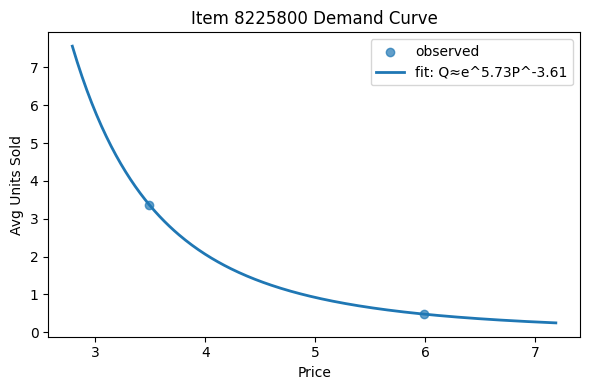

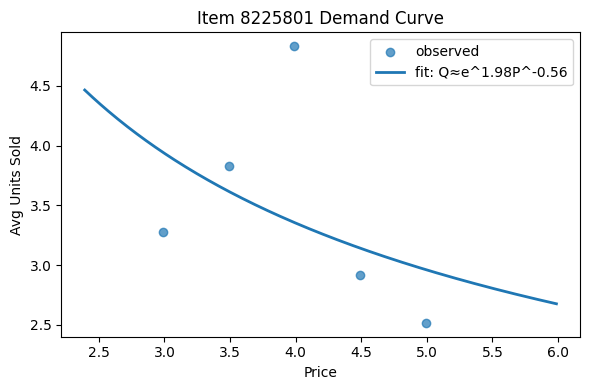

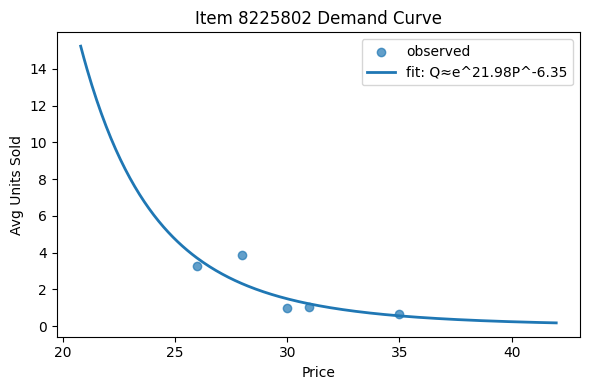

   item_id  optimal_price  max_revenue
0  8225800          2.792    21.101921
1  8225801          5.988    16.028813
2  8225802         20.792   316.753638


In [29]:
# trying to find some ideal p x q situations

df_optimized = price_grouped.copy()
df_optimized['est_revenue'] = df_optimized['active_price'] * df_optimized['avg_units_sold']

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

results = []

count = 0
for item_id, grp in price_grouped.groupby('item_id'):
    grp = grp.copy()
    # 1) Log‐transform your observed blocks
    grp['log_P'] = np.log(grp['active_price'])
    grp['log_Q'] = np.log(grp['avg_units_sold'])
    
    # 2) Fit the log–log demand curve
    X = sm.add_constant(grp['log_P'])
    y = grp['log_Q']
    model = sm.OLS(y, X).fit()
    alpha, beta = model.params['const'], model.params['log_P']
    
    # 3) Build a price grid (optionally wider than observed)
    P_min, P_max = grp['active_price'].min(), grp['active_price'].max()
    P_grid = np.linspace(P_min * 0.8, P_max * 1.2, 300)
    
    # 4) Predict Q and revenue on that grid
    Q_pred = np.exp(alpha) * P_grid**beta
    R_pred = P_grid * Q_pred
    
    # 5) Plot: observed points + fitted curve
    plt.figure(figsize=(6,4))
    plt.scatter(grp['active_price'], grp['avg_units_sold'], 
                label='observed', alpha=0.7)
    plt.plot(P_grid, Q_pred, 
             label=f'fit: Q≈e^{alpha:.2f}P^{beta:.2f}', linewidth=2)
    plt.xlabel('Price')
    plt.ylabel('Avg Units Sold')
    plt.title(f'Item {item_id} Demand Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 6) Record the revenue‐maximizing price for later
    best_idx = np.argmax(R_pred)
    results.append({
        'item_id':       item_id,
        'optimal_price': P_grid[best_idx],
        'max_revenue':   R_pred[best_idx]
    })
    count += 1
    if count > 2:
        break

# 7) (Optional) see the table of optimal prices
import pandas as pd
opt_df = pd.DataFrame(results)
print(opt_df)

In [33]:
# dump price_grouped to csv
price_grouped.to_csv('data/price_grouped_hmart.csv', index=False)

In [34]:
# trying a differnet approach than raw elasticity calculation 

df_new = df.copy() 

# want to just track, if reduction in price leads to an increase in units sold 
# first lets aggregate data by period 
def aggregate_data_by_period(df):
    df = (
        df
        .groupby(
            ['period_id', 'store_id', 'item_id'],
            as_index=False
        )
        .agg(
            active_price    = ('active_price', 'first'), # use the first active price but mark changes that are made
            active_price_changed = ('active_price', lambda s: s.nunique()>1), # mark if the active price changed so we can plot it later
            avg_regular_price   = ('regular_price', 'mean'), 
            avg_promo_price      = ('promo_price',    'mean'),
            avg_selling_price   = ('avg_selling_price', 'mean'),
            avg_unit_cost       = ('unit_cost',     'mean'),
            total_units_sold    = ('units_sold',    'sum'),
            avg_basket_size     = ('avg_basket_size','sum'),
            total_num_baskets   = ('num_baskets', 'sum'),
            total_promo_spending = ('promo_spending','sum'),
            total_revenue       = ('revenue', 'sum'),
            total_profit        = ('profit', 'sum'),
            total_promo_spending_selling_price_based = ('promo_spending (selling_price_based)', 'sum'),
            total_revenue_selling_price_based = ('revenue (selling_price_based)', 'sum'),
            total_profit_selling_price_based = ('profit (selling_price_based)', 'sum'),
            # we are not going to aggregate filled from data here because that was row level 
            # non aggregations here
            name = ('name', 'first'),
            categories = ('categories', 'first'),
            bb_id = ('bb_id', 'first'),
            merchant_id = ('merchant_id', 'first'),
            timezone = ('timezone', 'first'),
            period_start_local = ('period_start_local', 'first'),
            period_end_local = ('period_end_local', 'first'),
            on_promotion = ('on_promotion', 'first')
            
            
        )
    )
    df['weighted_average_promo_spending_ratio'] = df['total_promo_spending'] / df['total_revenue']
    df['weighted_average_promo_spending_ratio_selling_price_based'] = df['total_promo_spending_selling_price_based'] / df['total_revenue_selling_price_based']
    return df

df_agg = aggregate_data_by_period(df_new)
df_agg.head(20)


,period_id,store_id,item_id,active_price,active_price_changed,avg_regular_price,avg_promo_price,avg_selling_price,avg_unit_cost,total_units_sold,...,name,categories,bb_id,merchant_id,timezone,period_start_local,period_end_local,on_promotion,weighted_average_promo_spending_ratio,weighted_average_promo_spending_ratio_selling_price_based
0,0,1173,8225800,5.99,False,5.99,NaN,5.390000,1.9156,2,...,Frozen Udon 2.75lb(1.25kg),"[Ramen & Noodle, Udon & Frozen Noodles]",8902.0,17,America/New_York,2024-06-21 00:00:00,2024-07-05 00:00:00,False,0.0,0.206181
1,0,1173,8225801,4.49,False,4.49,NaN,3.276737,2.5306,104,...,Golden Curry Sauce Mix Mild 7.8oz(220g),"[Instant & Quick Food, Curry & Jjajang & Soup]",2319.0,17,America/New_York,2024-06-21 00:00:00,2024-07-05 00:00:00,False,0.0,0.436422
2,0,1173,8225802,34.99,False,34.99,NaN,34.990000,22.9081,7,...,Duck Packaged Fz Smoked/Sliced Half Duck (1 Pack),"[Meat, Duck,Others]",4439.0,17,America/New_York,2024-06-21 00:00:00,2024-07-05 00:00:00,False,0.0,0.028580
3,0,1173,8225803,4.99,False,4.99,NaN,4.590000,2.2300,12,...,Glass Noodles 15.87oz(450g),"[Ramen & Noodle, Vermicelli & Rice & Paper]",2397073.0,17,America/New_York,2024-06-21 00:00:00,2024-07-05 00:00:00,False,0.0,0.250887
4,0,1173,8225807,10.99,False,10.99,NaN,10.885238,5.2276,19,...,Marine Choco Boy 20PK 19.75oz(560g),"[Snacks & Candy & Nuts, Multi Snack]",6987.0,17,America/New_York,2024-06-21 00:00:00,2024-07-05 00:00:00,False,0.0,0.106664
5,0,1173,8225808,9.99,False,9.99,NaN,8.918571,5.3333,6,...,Cooked Black Rice Bowl 7.4oz(210g) 3 Packs,"[Instant & Quick Food, Cooked Rice]",3537.0,17,America/New_York,2024-06-21 00:00:00,2024-07-05 00:00:00,False,0.0,0.124337
6,0,1173,8225809,7.99,False,7.99,NaN,7.047143,3.9375,7,...,Stir-Fried Gan Jjajang Black Bean Sauce 7.48oz...,"[Instant & Quick Food, Curry & Jjajang & Soup]",6334.0,17,America/New_York,2024-06-21 00:00:00,2024-07-05 00:00:00,False,0.0,0.165006
7,0,1173,8225810,3.99,False,3.99,NaN,3.990000,2.4000,1,...,Instant Miso Soup Spinach 5.76oz(172.8g),"[Instant & Quick Food, Instant Soup & Stew & P...",2252.0,17,America/New_York,2024-06-21 00:00:00,2024-07-05 00:00:00,False,0.0,0.250627
8,0,1173,8225811,4.99,False,4.99,NaN,4.589226,3.4595,47,...,Neoguri Spicy 4.2oz(120g) 4 Packs,"[Ramen & Noodle, Bundle]",1724.0,17,America/New_York,2024-06-21 00:00:00,2024-07-05 00:00:00,False,0.0,0.244339
9,0,1173,8225812,1.99,False,1.99,NaN,1.519988,0.8875,61,...,Dukboki Sauce 1.76oz(50g),"[Instant & Quick Food, Tteokbokki & Dumpling &...",4140.0,17,America/New_York,2024-06-21 00:00:00,2024-07-05 00:00:00,False,0.0,1.308950


In [ ]:
# more simply, see if we can get a sense of how much price changes lead to changes in units sold between periods 

df_agg = df.copy()

df_agg = aggregate_data_by_period(df_agg)
df_agg.head(20)

# now we want to calculate the elasticity for each item 
# we will do this by fitting a power law model to the data 
# we will use the log-log model: log(Q) = alpha + beta * log(P)
# we will use the statsmodels library to fit the model 